# Hemodynamic exposure features + figures (Fig 1–2, eFig 2–4)

This notebook:
1. Builds per-patient hemodynamic exposure features from hemodynamic CSV files.
2. Generates manuscript figures: Fig 1, Fig 2, eFig 2, eFig 3, eFig 4.

**Before running:** edit the paths in the **Configuration** cell below.


In [ ]:
# =========================
# Configuration + imports
# =========================
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import seaborn as sns

# ---- Paths ----
DATA_DIR = Path(r"/path/to/hemo_files")                  # folder with per-patient CSVs: <ID>_Hemodynamics.csv
COHORT_IDS_CSV = Path(r"/path/to/cohort_ids.csv")        # CSV containing cohort IDs
COVS_CSV = Path(r"/path/to/df_covariates.csv")           # covariates (+ outcome) for adjusted models

# ---- Column names ----
ID_COL = "pat_enc_csn_sid"
OUTCOME = "aki_by_labs"
CI_COL = "CI"
MAP_COL = "MAP_mmHg"

# ---- Signal sampling ----
SAMPLE_RATE_SEC = 5

# ---- Thresholds ----
MAP_THRESH = 65
CI_THRESH  = 2.2

# ---- Outputs ----
OUT_FEATURES_CSV = Path("hemo_features.csv")


In [10]:
# =========================
# Helper functions
# =========================
def _clean_id(s: pd.Series) -> pd.Series:
    """Extract numeric ID from strings."""
    return s.astype(str).str.extract(r"(\d+)", expand=False)

def extract_pid_from_filename(fname: str) -> str:
    """Parse '1000260577_Hemodynamics.csv' -> '1000260577'."""
    base = os.path.basename(fname)
    m = re.match(r"(\d+)_", base)
    if not m:
        raise ValueError(f"Could not parse ID from filename: {fname}")
    return m.group(1)

def load_series_interp(df: pd.DataFrame, col: str) -> np.ndarray:
    """Numeric series with linear interpolation + bfill/ffill."""
    if col not in df.columns:
        raise KeyError(f"Missing column '{col}'. Found: {list(df.columns)}")
    s = pd.to_numeric(df[col], errors="coerce")
    s = s.interpolate("linear").bfill().ffill()
    return s.to_numpy()

def minutes_in_mask(mask: np.ndarray, sample_rate_sec: int) -> float:
    return float(np.sum(mask)) * sample_rate_sec / 60.0

def map_auc_below_threshold(map_vals: np.ndarray, thresh: float, sample_rate_sec: int) -> float:
    """AUC of (thresh - MAP) when MAP < thresh. Units: mmHg·min."""
    deficit = np.clip(thresh - map_vals, a_min=0, a_max=None)  # 0 when MAP>=thresh
    return float(np.sum(deficit) * sample_rate_sec / 60.0)


In [11]:
# =========================
# Build hemodynamic exposure features (per patient)
# =========================

# Load cohort IDs
ids_df = pd.read_csv(COHORT_IDS_CSV, dtype={ID_COL: str})
if ID_COL not in ids_df.columns:
    raise KeyError(f"'{ID_COL}' not found in {COHORT_IDS_CSV}. Columns: {list(ids_df.columns)}")

cohort_ids = set(_clean_id(ids_df[ID_COL]).dropna().tolist())
print(f"Cohort IDs loaded: {len(cohort_ids)}")

# Filter files by cohort IDs
all_files = [p for p in DATA_DIR.iterdir() if p.suffix.lower() == ".csv"]
filtered_files = []
seen = set()

for p in all_files:
    try:
        pid = extract_pid_from_filename(p.name)
    except Exception:
        continue
    if pid in cohort_ids and pid not in seen:
        filtered_files.append(p)
        seen.add(pid)

# Build features per subject
rows = []
errors = 0

for p in filtered_files:
    try:
        pid = extract_pid_from_filename(p.name)
        df = pd.read_csv(p)

        CI  = load_series_interp(df, CI_COL)
        MAP = load_series_interp(df, MAP_COL)

        ci_hi  = CI >= CI_THRESH
        ci_lo  = CI <  CI_THRESH
        map_lo = MAP <  MAP_THRESH
        map_hi = MAP >= MAP_THRESH

        a_min = minutes_in_mask(ci_hi & map_lo, SAMPLE_RATE_SEC)  # CI>=2.2 & MAP<65
        b_min = minutes_in_mask(ci_hi & map_hi, SAMPLE_RATE_SEC)  # CI>=2.2 & MAP>=65
        c_min = minutes_in_mask(ci_lo & map_lo, SAMPLE_RATE_SEC)  # CI<2.2  & MAP<65
        d_min = minutes_in_mask(ci_lo & map_hi, SAMPLE_RATE_SEC)  # CI<2.2  & MAP>=65

        map_auc_65 = map_auc_below_threshold(MAP, MAP_THRESH, SAMPLE_RATE_SEC)

        rows.append({
            ID_COL: pid,
            "time_joint_MAP_lt65_CI_ge2_2_min": a_min,
            "time_joint_MAP_ge65_CI_ge2_2_min": b_min,
            "time_joint_MAP_lt65_CI_lt2_2_min": c_min,
            "time_joint_MAP_ge65_CI_lt2_2_min": d_min,
            "AUC_MAP_lt65_mmHg_min": map_auc_65,
        })

    except Exception as e:
        errors += 1
        print(f"⚠️ {p.name} failed: {e}")

hemo_features = pd.DataFrame(rows).sort_values(ID_COL).reset_index(drop=True)
print(f"Built features for {hemo_features.shape[0]} subjects.")

# Save
hemo_features.to_csv(OUT_FEATURES_CSV, index=False)


Cohort IDs loaded: 1972
Built features for 1972 subjects.


## Fig 1 — Distribution of exposure minutes by CI/MAP category (boxplot)

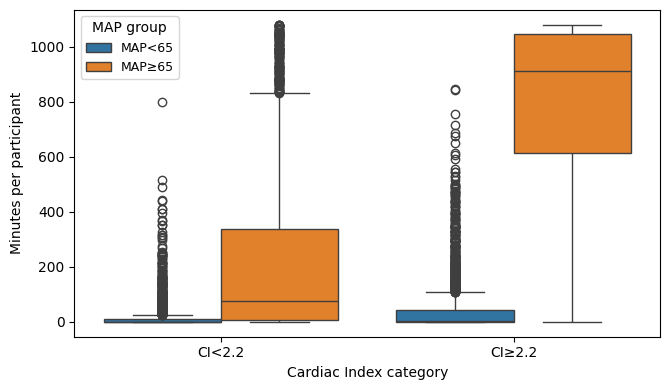

In [12]:
# Fig 1: boxplot of minutes per participant by CI category, colored by MAP group
# Uses the four quadrant time variables built above.

# Reconstruct a/b/c/d minutes from renamed columns (for plotting only)
tmp = hemo_features.rename(columns={
    "time_joint_MAP_lt65_CI_ge2_2_min": "a_min",
    "time_joint_MAP_ge65_CI_ge2_2_min": "b_min",
    "time_joint_MAP_lt65_CI_lt2_2_min": "c_min",
    "time_joint_MAP_ge65_CI_lt2_2_min": "d_min",
})

df_hi = tmp[["a_min","b_min"]].melt(var_name="MAP_group", value_name="minutes")
df_hi["CI_group"] = "CI≥2.2"
df_hi["MAP_group"] = df_hi["MAP_group"].map({"a_min":"MAP<65","b_min":"MAP≥65"})

df_lo = tmp[["c_min","d_min"]].melt(var_name="MAP_group", value_name="minutes")
df_lo["CI_group"] = "CI<2.2"
df_lo["MAP_group"] = df_lo["MAP_group"].map({"c_min":"MAP<65","d_min":"MAP≥65"})

plot_df = pd.concat([df_lo, df_hi], ignore_index=True)

plt.figure(figsize=(6.8, 4.0))
sns.boxplot(
    data=plot_df, x="CI_group", y="minutes", hue="MAP_group",
    showfliers=True
)
plt.xlabel("Cardiac Index category")
plt.ylabel("Minutes per participant")
plt.legend(loc="upper left", fontsize=9, title="MAP group", frameon=True)
plt.tight_layout()
# plt.savefig("Fig1_CI_MAP_minutes_boxplot.jpg", dpi=300)
plt.show()


## Fig 2 — Subgroup forest plot (binary exposure: any vs none in a CI/MAP quadrant)

Dropped 'surgery_Other' as surgery reference.


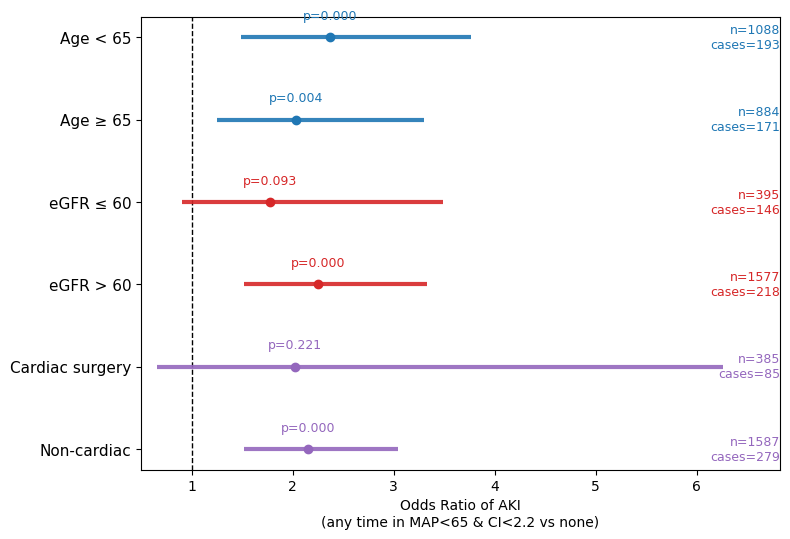

In [13]:
# Fig 2: adjusted subgroup forest plot for binary exposure in one quadrant.
# Choose TIME_COL = one of:
#   time_joint_MAP_lt65_CI_ge2_2_min
#   time_joint_MAP_ge65_CI_ge2_2_min
#   time_joint_MAP_lt65_CI_lt2_2_min
#   time_joint_MAP_ge65_CI_lt2_2_min

TIME_COL = "time_joint_MAP_lt65_CI_lt2_2_min"  # default: low MAP & low CI
EXPO_COL = f"{TIME_COL}_any"
SCALE_MINUTES = 10.0  # used in other analyses; here exposure is binary

# Load covariates (+ outcome)
cov = pd.read_csv(COVS_CSV, dtype={ID_COL: str})
cov[ID_COL] = _clean_id(cov[ID_COL])

# Merge covariates with exposure minutes
df = cov.merge(hemo_features[[ID_COL, TIME_COL]], on=ID_COL, how="inner")

# Covariates used in primary analysis (edit as needed; outcome excluded below)
covs = [
    'albuminuria','gender','emergent_status','serum_albumin','serum_sodium',
    'RAAS_blockade_use','eGFR','surgery_time','age_yr','CHF','PERIVASC','HTN',
    'CHRNLUNG','LIVER','COAG','WGHTLOSS','LYTES','exposure_cad','diuretic_use',
    'pat_BMI','beta_blocker','preop_HGB','diabetes','stroke','cancer','anemia',
    'substance_use','Psych_condition','surgery_GI','surgery_NeurB','surgery_Card',
    'surgery_Spine','surgery_VASC','surgery_Trans','surgery_THOR','surgery_Other'
]
covs = [c for c in covs if c in df.columns and c != OUTCOME]

# Drop one surgery dummy as reference
surg = [c for c in covs if c.startswith("surgery_")]
if surg:
    ref = "surgery_Other" if "surgery_Other" in surg else surg[-1]
    covs = [c for c in covs if c != ref]
    print(f"Dropped '{ref}' as surgery reference.")

# Numeric coercion
for c in covs + [OUTCOME, TIME_COL]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[OUTCOME, TIME_COL]).copy()
df[OUTCOME] = df[OUTCOME].astype(int)

# Binary exposure: any vs none
df[EXPO_COL] = (df[TIME_COL] > 0).astype(int)

def fit_subset(label, mask):
    d = df.loc[mask].copy()
    if d.empty or d[EXPO_COL].nunique() < 2:
        return {"label": label, "N": int(len(d)), "cases": int(d[OUTCOME].sum()) if len(d) else 0,
                "OR": np.nan, "lo": np.nan, "hi": np.nan, "p": np.nan}

    cov_use = [c for c in covs if d[c].nunique(dropna=True) > 1]
    X = d[cov_use + [EXPO_COL]]
    y = d[OUTCOME]

    ok = X.notna().all(axis=1) & y.notna()
    X = sm.add_constant(X.loc[ok], has_constant="add")
    y = y.loc[ok].astype(int)

    if y.nunique() < 2 or len(y) < 20:
        return {"label": label, "N": int(len(y)), "cases": int(y.sum()),
                "OR": np.nan, "lo": np.nan, "hi": np.nan, "p": np.nan}

    m = sm.Logit(y, X).fit(disp=0, cov_type="HC3")
    b, se = m.params[EXPO_COL], m.bse[EXPO_COL]
    OR, lo, hi = np.exp(b), np.exp(b - 1.96*se), np.exp(b + 1.96*se)
    p = m.pvalues[EXPO_COL]
    return {"label": label, "N": int(len(y)), "cases": int(y.sum()), "OR": OR, "lo": lo, "hi": hi, "p": p}

# Subgroups (edit/extend as needed)
subs = [
    ("Age < 65",  df["age_yr"] < 65),
    ("Age ≥ 65",  df["age_yr"] >= 65),
    ("eGFR ≤ 60", df["eGFR"] <= 60),
    ("eGFR > 60", df["eGFR"] > 60),
]
if "surgery_Card" in df.columns:
    subs += [("Cardiac surgery", df["surgery_Card"] == 1),
             ("Non-cardiac",     df["surgery_Card"] != 1)]

forest = pd.DataFrame([fit_subset(lbl, m) for lbl, m in subs])

# ---- Plot (keep colors/style consistent with your original) ----
y = []
labels = []
for i in range(0, len(subs), 2):
    y.extend([-(i+0), -(i+1)])
    labels.extend([subs[i][0], subs[i+1][0]])
    if i + 2 < len(subs):
        y.append(np.nan)
        labels.append("")

plot_idx = [i for i, lab in enumerate(labels) if lab != ""]
y_plot = [y[i] for i in plot_idx]
F = forest.iloc[:len(y_plot)].copy()

xmin = np.nanmin(F["lo"].values) if np.isfinite(F["lo"]).any() else 0.8
xmax = np.nanmax(F["hi"].values) if np.isfinite(F["hi"]).any() else 2.0
pad  = 0.1 * (xmax - xmin)
xmin, xmax = max(0.5, xmin - pad), xmax + pad

fig, ax = plt.subplots(figsize=(8, 5.5))
ax.axvline(1.0, color="k", linestyle="--", linewidth=1)

# colors per subgroup block (age, eGFR, surgery)
colors = ["#1f77b4", "#1f77b4", "#d62728", "#d62728", "#9467bd", "#9467bd"][:len(y_plot)]

for k, yi in enumerate(y_plot):
    OR, lo, hi, p, n, cases = F.loc[k, ["OR","lo","hi","p","N","cases"]]
    ax.hlines(yi, lo, hi, color=colors[k], lw=3, alpha=0.9)
    ax.plot(OR, yi, "o", color=colors[k], ms=6)
    ax.text(OR, yi + 0.18, f"p={p:.3f}" if np.isfinite(p) else "p=NA",
            ha="center", va="bottom", fontsize=9, color=colors[k])
    ax.text(xmax, yi, f"n={int(n)}\ncases={int(cases)}",
            ha="right", va="center", fontsize=9, color=colors[k])

ax.set_yticks(y_plot)
ax.set_yticklabels([labels[i] for i in plot_idx], fontsize=11)
ax.set_xlim(xmin, xmax)

exposure_labels = {
    "time_joint_MAP_lt65_CI_ge2_2_min": "any time in MAP<65 & CI≥2.2 vs none",
    "time_joint_MAP_ge65_CI_ge2_2_min": "any time in MAP≥65 & CI≥2.2 vs none",
    "time_joint_MAP_lt65_CI_lt2_2_min": "any time in MAP<65 & CI<2.2 vs none",
    "time_joint_MAP_ge65_CI_lt2_2_min": "any time in MAP≥65 & CI<2.2 vs none",
}
ax.set_xlabel("Odds Ratio of AKI\n(" + exposure_labels.get(TIME_COL, TIME_COL) + ")")

plt.tight_layout()
# plt.savefig("Fig2_forest_binary_subgroups.jpg", dpi=300)
plt.show()


## eFig 2 — CI histogram

Files used: 1972 | Samples pooled: 25,485,622


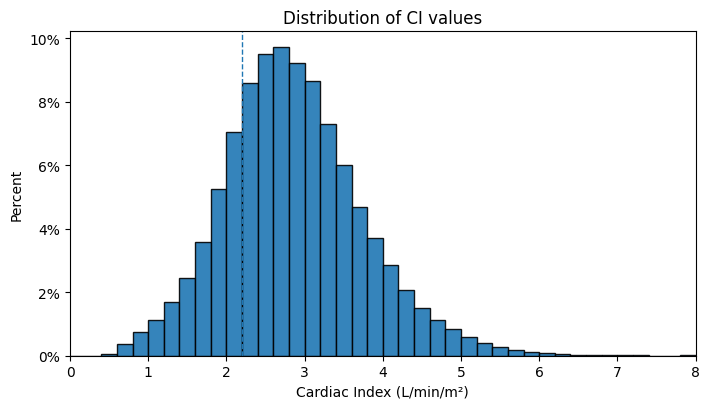

In [14]:
# eFig 2: pooled CI distribution across cohort, binned in 0.2 increments
ci_thresh = CI_THRESH

grid_step = 0.1
values_per_bin = 2                 # 2 ticks/bin => 0.2 CI width
range_min, range_max = 0.0, 8.0    # match manuscript axis

# ---- bins aligned to the 0.1 grid (0.2-wide bins) ----
scale   = int(round(1.0 / grid_step))            # 10 for 0.1
min_int = int(round(range_min * scale))          # 0 -> 0
max_int = int(round(range_max * scale))          # 8.0 -> 80
edges_int = np.arange(min_int, max_int + values_per_bin, values_per_bin)
bins = edges_int / scale                         # back to CI units

# ---- accumulate histogram counts (streaming) ----
counts = np.zeros(len(bins) - 1, dtype=float)
total_samples = 0

for p in filtered_files:  # expect Path objects
    try:
        s = pd.read_csv(p, usecols=[CI_COL])
        ci = pd.to_numeric(s[CI_COL], errors="coerce").interpolate("linear").bfill().ffill().to_numpy()
        ci = ci[np.isfinite(ci)]
        if ci.size == 0:
            continue

        # IMPORTANT: clip but DO NOT round (rounding creates spiky artifacts)
        ci = np.clip(ci, range_min, range_max)

        c, _ = np.histogram(ci, bins=bins)
        counts += c
        total_samples += ci.size

    except Exception as e:
        print(f"Skipping {getattr(p, 'name', str(p))}: {e}")

percent = 100.0 * counts / counts.sum()
centers = (bins[:-1] + bins[1:]) / 2
widths  = np.diff(bins)

print(f"Files used: {len(filtered_files)} | Samples pooled: {total_samples:,}")

# ---- plot (percent) ----
plt.figure(figsize=(7.2, 4.2))
plt.bar(centers, percent, width=widths, align="center", edgecolor="black", alpha=0.9)
plt.axvline(ci_thresh, linestyle="--", linewidth=1, color="tab:blue")
plt.title("Distribution of CI values")
plt.xlabel("Cardiac Index (L/min/m²)")
plt.ylabel("Percent")
plt.xlim(range_min, range_max)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
plt.tight_layout()
# plt.savefig("eFig2_CI_hist_percent_0p2bins.jpg", dpi=300)
plt.show()


## eFig 3 — Correlation among hemodynamic exposure features (Spearman)

Spearman correlation computed over 5 features


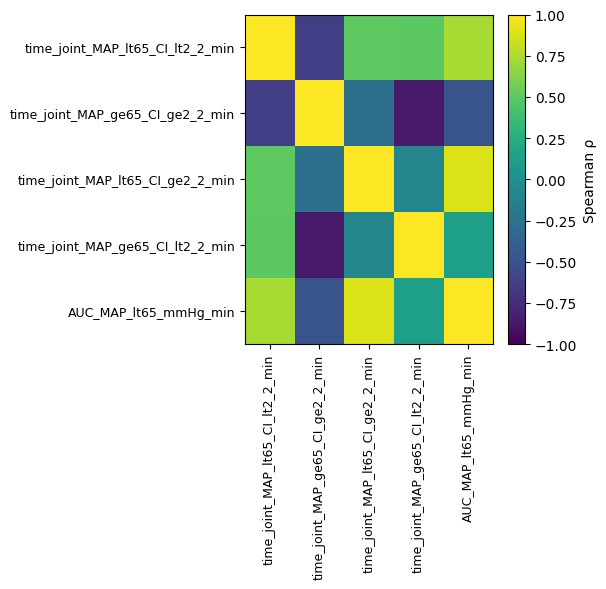

In [15]:
FEATURE_COLS = [
    "time_joint_MAP_lt65_CI_lt2_2_min",
    "time_joint_MAP_ge65_CI_ge2_2_min",
    "time_joint_MAP_lt65_CI_ge2_2_min",
    "time_joint_MAP_ge65_CI_lt2_2_min",
    "AUC_MAP_lt65_mmHg_min",
]

num = hemo_features[FEATURE_COLS].apply(pd.to_numeric, errors="coerce")

# Drop constants
const_cols = [c for c in num.columns if num[c].nunique(dropna=True) <= 1]
num = num.drop(columns=const_cols)

corr = num.corr(method="spearman")
n = corr.shape[0]
print(f"Spearman correlation computed over {n} features" + (f" (dropped constants: {const_cols})" if const_cols else ""))

fig, ax = plt.subplots(figsize=(max(6, 0.9*n), max(6, 0.9*n)))
im = ax.imshow(corr.values, vmin=-1, vmax=1, aspect="auto")
ax.set_xticks(range(n)); ax.set_yticks(range(n))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=9)
ax.set_yticklabels(corr.columns, fontsize=9)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Spearman ρ")
plt.tight_layout()
# plt.savefig("eFig3_spearman_corr_hemo.jpg", dpi=300)
plt.show()


## eFig 4 — Unadjusted and adjusted OR heatmaps (per 10 minutes in category)

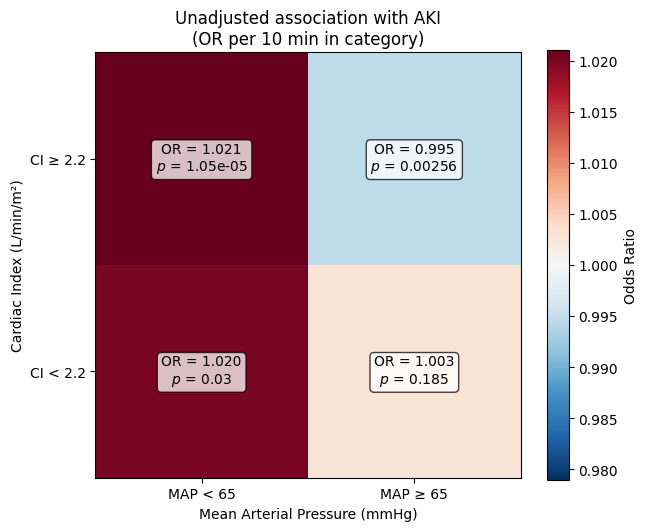

Adjusted model: dropped 'surgery_Other' as surgery reference.


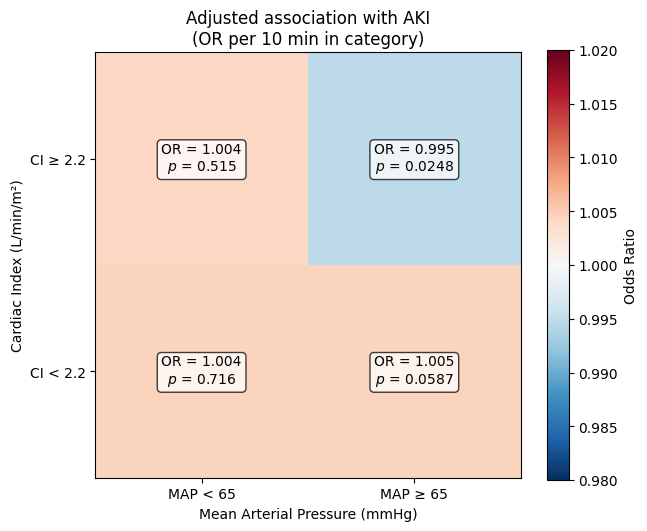

In [16]:
TIME_COLS_RAW = [
    "time_joint_MAP_lt65_CI_ge2_2_min",
    "time_joint_MAP_ge65_CI_ge2_2_min",
    "time_joint_MAP_lt65_CI_lt2_2_min",
    "time_joint_MAP_ge65_CI_lt2_2_min",
]
SCALE_MINUTES = 10.0

# Helper: fit logit with HC3 and return OR/CI/p + AUC
def fit_logit_hc3(df, y_col, x_scaled, covariates=None):
    covariates = covariates or []
    use_cols = [y_col] + covariates + [x_scaled]
    m = df[use_cols].dropna().copy()
    y = m[y_col].astype(int)
    X = sm.add_constant(m[covariates + [x_scaled]], has_constant="add")

    model = sm.Logit(y, X).fit(disp=0, cov_type="HC3")
    b, se = model.params[x_scaled], model.bse[x_scaled]
    p = model.pvalues[x_scaled]
    pred = model.predict(X)
    auc = roc_auc_score(y, pred)

    return float(np.exp(b)), float(np.exp(b - 1.96*se)), float(np.exp(b + 1.96*se)), float(p), float(auc), int(len(m))

def plot_or_heatmap(res_df, title):
    R = res_df.set_index("time_col")
    OR = np.array([[R.loc[TIME_COLS_RAW[0],"OR"], R.loc[TIME_COLS_RAW[1],"OR"]],
                   [R.loc[TIME_COLS_RAW[2],"OR"], R.loc[TIME_COLS_RAW[3],"OR"]]], float)
    LO = np.array([[R.loc[TIME_COLS_RAW[0],"LO"], R.loc[TIME_COLS_RAW[1],"LO"]],
                   [R.loc[TIME_COLS_RAW[2],"LO"], R.loc[TIME_COLS_RAW[3],"LO"]]], float)
    HI = np.array([[R.loc[TIME_COLS_RAW[0],"HI"], R.loc[TIME_COLS_RAW[1],"HI"]],
                   [R.loc[TIME_COLS_RAW[2],"HI"], R.loc[TIME_COLS_RAW[3],"HI"]]], float)
    P  = np.array([[R.loc[TIME_COLS_RAW[0],"P"],  R.loc[TIME_COLS_RAW[1],"P"]],
                   [R.loc[TIME_COLS_RAW[2],"P"],  R.loc[TIME_COLS_RAW[3],"P"]]], float)

    span = max(abs(OR - 1).max(), 0.02)
    vmin, vmax = 1 - span, 1 + span

    fig, ax = plt.subplots(figsize=(6.6, 5.4))
    im = ax.imshow(OR, cmap="RdBu_r", vmin=vmin, vmax=vmax)

    ax.set_xticks([0,1]); ax.set_xticklabels([r"MAP < 65", r"MAP ≥ 65"])
    ax.set_yticks([0,1]); ax.set_yticklabels([r"CI ≥ 2.2", r"CI < 2.2"])
    ax.set_xlabel("Mean Arterial Pressure (mmHg)")
    ax.set_ylabel("Cardiac Index (L/min/m²)")
    ax.set_title(f"{title}\n(OR per {int(SCALE_MINUTES)} min in category)")

    for i in range(2):
        for j in range(2):
            ax.text(
                j, i,
                f"OR = {OR[i,j]:.3f}\n" + rf"$p$ = {P[i,j]:.3g}",
                ha="center", va="center", fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.75)
            )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Odds Ratio")
    plt.tight_layout()
    plt.show()

# --- Unadjusted ---
out = pd.read_csv(COVS_CSV, dtype={ID_COL: str})
out[ID_COL] = _clean_id(out[ID_COL])
out = out[[ID_COL, OUTCOME]].dropna()
out[OUTCOME] = pd.to_numeric(out[OUTCOME], errors="coerce").dropna().astype(int)

df_u = hemo_features.merge(out, on=ID_COL, how="inner").copy()

rows = []
for tcol in TIME_COLS_RAW:
    x_scaled = f"{tcol}_per{int(SCALE_MINUTES)}min"
    df_u[x_scaled] = pd.to_numeric(df_u[tcol], errors="coerce") / SCALE_MINUTES
    OR, LO, HI, P, AUC, N = fit_logit_hc3(df_u, OUTCOME, x_scaled, covariates=[])
    rows.append({"time_col": tcol, "OR": OR, "LO": LO, "HI": HI, "P": P, "AUC": AUC, "N": N})

unadj = pd.DataFrame(rows)
plot_or_heatmap(unadj, "Unadjusted association with AKI")

# --- Adjusted ---
df_cov = pd.read_csv(COVS_CSV, dtype={ID_COL: str})
df_cov[ID_COL] = _clean_id(df_cov[ID_COL])

df_a = df_cov.merge(hemo_features[[ID_COL] + TIME_COLS_RAW], on=ID_COL, how="inner").copy()

# Same covariate list as primary analysis (edit as needed; excludes outcome below)
provided_covs = [
    'albuminuria','gender','emergent_status','serum_albumin','serum_sodium',
    'RAAS_blockade_use','eGFR','surgery_time','age_yr','CHF','PERIVASC','HTN',
    'CHRNLUNG','LIVER','COAG','WGHTLOSS','LYTES','exposure_cad','diuretic_use',
    'pat_BMI','blood_transfusions','beta_blocker','postop_pressor_infusion',
    'preop_HGB','diabetes','stroke','cancer','anemia','substance_use','Psych_condition',
    'surgery_GI','surgery_NeurB','surgery_Card','surgery_Spine','surgery_VASC',
    'surgery_Trans','surgery_THOR','surgery_Other'
]
covs = [c for c in provided_covs if c in df_a.columns and c != OUTCOME]

# Drop one surgery dummy as reference
surg = [c for c in covs if c.startswith("surgery_")]
if surg:
    ref = "surgery_Other" if "surgery_Other" in surg else surg[-1]
    covs = [c for c in covs if c != ref]
    print(f"Adjusted model: dropped '{ref}' as surgery reference.")

# Coerce numeric
for c in covs + [OUTCOME] + TIME_COLS_RAW:
    if c in df_a.columns:
        df_a[c] = pd.to_numeric(df_a[c], errors="coerce")

df_a = df_a.dropna(subset=[OUTCOME]).copy()
df_a[OUTCOME] = df_a[OUTCOME].astype(int)

rows = []
for tcol in TIME_COLS_RAW:
    x_scaled = f"{tcol}_per{int(SCALE_MINUTES)}min"
    df_a[x_scaled] = df_a[tcol] / SCALE_MINUTES
    OR, LO, HI, P, AUC, N = fit_logit_hc3(df_a, OUTCOME, x_scaled, covariates=covs)
    rows.append({"time_col": tcol, "OR": OR, "LO": LO, "HI": HI, "P": P, "AUC": AUC, "N": N})

adj = pd.DataFrame(rows)
plot_or_heatmap(adj, "Adjusted association with AKI")
